In [1]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

#disable_eager_execution()

In [2]:
class MyRNN(layers.Layer):
    def __init__(self, units):
        super(MyRNN, self).__init__()
        self.units = units
        self.gru = layers.Bidirectional(layers.GRU(units, return_sequences=True))
        
    def call(self, inputs):
        #sequences, masks = inputs
        sequences, seq_lengths = inputs
        masks = tf.sequence_mask(seq_lengths)
        y = self.gru(sequences, mask=masks)
        
        return y
    
    def get_config(self):
        return {'units': self.units}
    
def mymodel():
    seq_data = keras.Input(shape=(None, 1),  name="seq_data")
    seq_lengths = keras.Input(shape=(), name="seq_lengths", dtype=tf.int32)
    conv = layers.Conv1D(32, 3, strides=1, padding='same', activation='relu')(seq_data)
    rnn = MyRNN(32)((conv, seq_lengths))
    dense = layers.Dense(5, name="signal_mask")(rnn)
    model = keras.Model(inputs=[seq_data, seq_lengths], outputs=[dense])
    
    return model

In [3]:
#strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0', '/device:GPU:1')
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CollectiveCommunication.AUTO
Number of devices: 2


In [4]:
with strategy.scope():
    model = mymodel()
    model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        )

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_data (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     128         seq_data[0][0]                   
__________________________________________________________________________________________________
seq_lengths (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
my_rnn (MyRNN)                  (None, None, 64)     12672       conv1d[0][0]                     
                                                                 seq_lengths[0][0]     

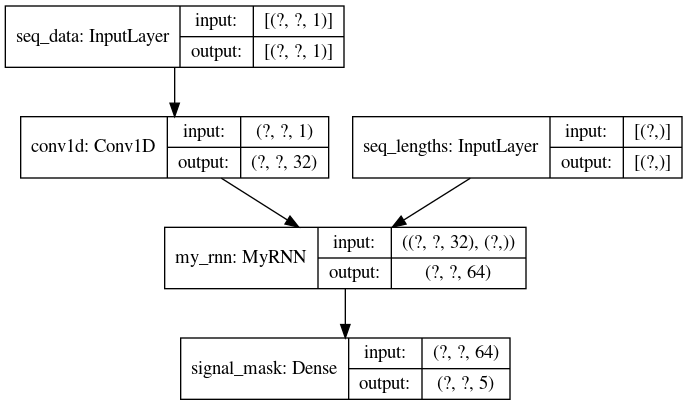

In [5]:
print(model.summary())
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
def prepare_dataset(num_records, time_step, signal_length, repeats_per_epoch, batch_size):
    #batch_size = 1
    #time_step = 100
    #signal_length = 100
    sequences = np.random.rand(num_records, time_step, 1)
    seq_lengths = np.array([signal_length]*num_records)
    signal_mask = np.random.randint(5, size=(num_records, time_step))

    inputs = tf.data.Dataset.from_tensor_slices((sequences, seq_lengths))
    signal_masks = tf.data.Dataset.from_tensor_slices(signal_mask)
    dataset = tf.data.Dataset.zip((inputs, signal_masks))
    dataset = dataset.repeat(repeats_per_epoch).batch(batch_size)
    
    return dataset

In [7]:
dataset = prepare_dataset(
    num_records=1,
    time_step=100,
    signal_length=100,
    repeats_per_epoch=10,
    batch_size=2
)

In [8]:
model.fit(dataset, epochs=10)

Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Collective batch_all_reduce: 10 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 10 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
5/5 [==============================] - 3s 525ms/step - loss: 1.6027
INFO:tensorflow:Collective batch_